In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import datetime
from scipy.stats import sem
import matplotlib.cm as cm
import pathlib
import traceback
import configs

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from predify.utils.training import train_pcoders, eval_pcoders

from models.networks_2022 import BranchedNetwork

In [2]:
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

# Parameters

In [5]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}1_checkpoints/'
tensorboard_dir = f'{engram_dir}1_tensorboard/'
activations_dir = f'{engram_dir}3_activations/pnet_babble/'

In [6]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


# Helper functions

In [7]:
def get_accuracy(results):
    labels = np.array(results['label'])
    timesteps = []
    accuracies = [] # p
    delta_accuracies = [] # p - p_ff
    
    n_timesteps = 5
    for i in range(labels.size):
        label = labels[i]
        ff_acc = None
        for t in range(n_timesteps):
            output = results[f'{t}_output'][i]
            acc_t = (output == label).astype(float)
            if t == 0:
                ff_acc = acc_t
            timesteps.append(t)
            accuracies.append(acc_t)
            delta_accuracies.append(acc_t - ff_acc)

    timesteps = np.array(timesteps)
    accuracies = np.array(accuracies)
    delta_accuracies = np.array(delta_accuracies)
            
    return timesteps, accuracies, delta_accuracies

In [8]:
bgs = ['pinkNoise', 'AudScene', 'Babble8Spkr']
snrs = [-9.0, -6.0, -3.0, 0.0, 3.0]

In [9]:
def plot_by_snr_individual(val_key, figname=None, yticks=None):
    barWidth = 0.18
    x1 = np.arange(5) - barWidth*5/2
    colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
    
    for _id in np.unique(df['ID']):
        fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))
        id_df = df[df['ID'] == _id]
        print(np.mean(id_df[val_key]))
        for snr_i, snr in enumerate(np.unique(df['SNR'])):
            for t in [1, 2, 3, 4]:
                vals = id_df[(id_df['SNR']==snr) & (id_df['Timesteps']==t)]
                vals = vals[val_key]
                vals = np.array(vals)
                avg = np.mean(vals)
                plt.bar(
                    x1[snr_i] + barWidth*t, avg,
                    width=barWidth, color=colors[t-1],
                    label=t)
        plt.xticks([0,1,2,3,4], [-9, -6, -3, 0, 3])
        if yticks != None:
            plt.yticks(yticks)
        plt.ylabel(val_key)
        plt.xlabel('SNR')
        if figname is not None:
            plt.savefig(f'{figname}.svg', dpi=300)
        plt.show()

In [10]:
def plot_by_snr_mean(val_key, figname=None, yticks=None):
    barWidth = 0.18
    x1 = np.arange(5) - barWidth*5/2
    colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
    fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))

    for snr_i, snr in enumerate(np.unique(df['SNR'])):
        for t in [1, 2, 3, 4]:
            vals = df[(df['SNR']==snr) & (df['Timesteps']==t)]
            vals = vals[val_key]
            vals = np.array(vals)
            avg = np.mean(vals)
            err = sem(vals)
            label = t if snr_i==0 else None
            plt.bar(
                x1[snr_i] + barWidth*t, avg,
                width=barWidth, color=colors[t-1],
                yerr=err, capsize=0, label=label)
    plt.xticks([0,1,2,3,4], [-9, -6, -3, 0, 3])
    if yticks != None:
        plt.yticks(yticks)
    plt.ylabel(val_key)
    plt.xlabel('SNR')
    plt.axhline(0, color='lightgray')
    plt.legend(title='Timesteps')
    plt.tight_layout()
    if figname is not None:
        plt.savefig(f'{figname}.svg', dpi=300)
    plt.show()

In [11]:
def plot_by_bg_individual(val_key, figname=None, yticks=None):
    barWidth = 0.18
    x1 = np.arange(5) - barWidth*5/2
    colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
    
    for _id in np.unique(df['ID']):
        fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))
        id_df = df[df['ID'] == _id]
        print(np.mean(id_df[val_key]))
        for bg_i, bg in enumerate(['Babble8Spkr', 'AudScene', 'pinkNoise']):
            for t in [1, 2, 3, 4]:
                vals = id_df[(id_df['BG']==bg) & (id_df['Timesteps']==t)]
                vals = vals[val_key]
                vals = np.array(vals)
                avg = np.mean(vals)
                plt.bar(
                    x1[bg_i] + barWidth*t, avg,
                    width=barWidth, color=colors[t-1],
                    label=t)
        plt.xticks(
            [0, 1, 2],
            ['8-Speaker\nBabble', 'Auditory\nScene', 'Pink Noise'])
        if yticks != None:
            plt.yticks(yticks)
        plt.ylabel(val_key)
        if figname is not None:
            plt.savefig(f'{figname}.svg', dpi=300)
        plt.show()

In [21]:
def plot_by_bg_mean(val_key, figname=None, yticks=None, ylim=None):
    barWidth = 0.18
    x1 = np.arange(5) - barWidth*5/2
    colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
    fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))
    for bg_i, bg in enumerate(['Babble8Spkr', 'AudScene', 'pinkNoise']):
        for t in [1, 2, 3, 4]:
            vals = df[(df['BG']==bg) & (df['Timesteps']==t)]
            vals = vals[val_key]
            vals = np.array(vals)
            avg = np.mean(vals)
            err = sem(vals)
            plt.bar(
                x1[bg_i] + barWidth*t, avg, yerr=err,
                width=barWidth, color=colors[t-1],
                label=t)
    plt.xticks(
        [0, 1, 2],
        ['8-Speaker\nBabble', 'Auditory\nScene', 'Pink Noise'])
    if yticks != None:
        plt.yticks(yticks)
    if ylim != None:
        plt.ylim(ylim)
    plt.ylabel(val_key)
    if figname is not None:
        plt.savefig(f'{figname}.png', dpi=300)
    plt.show()

# Collect Data

In [13]:
data = {}
data['Accuracy'] = [] # p
data['$\Delta$ Accuracy'] = [] # p - p_ff for each bg, snr
data['Timesteps'] = []
data['SNR'] = []
data['BG'] = []
data['ID'] = []

for bg in bgs:
    for snr in snrs:
        activ_dir = f'{activations_dir}{bg}_snr{int(snr)}/'
        for results_file in os.listdir(activ_dir):
            results_filepath = f'{activ_dir}{results_file}'
            try:
                results = h5py.File(results_filepath, 'r')
            except:
                print(results_filepath)
                traceback.print_exc()
                continue
            timesteps, accs, delta_accs = get_accuracy(results)

            # Collect accuracy results by labels
            for t in [0, 1, 2, 3, 4]:
                idxs = timesteps==t
                data['Accuracy'].append(np.mean(accs[idxs]))
                data['$\Delta$ Accuracy'].append(np.mean(delta_accs[idxs]))
                data['Timesteps'].append(t)
                data['SNR'].append(snr)
                data['BG'].append(bg)
                data['ID'].append(results_file)
df = pd.DataFrame(data)

bg_avgs = {}
for bg in np.unique(df['BG']):
    bg_avgs[bg] = {}
    for snr in np.unique(df['SNR']):
        ff_df = df[df['Timesteps']==0]
        bg_avgs[bg][snr] = np.mean(
            ff_df[(ff_df['BG'] == bg) & (ff_df['SNR'] ==snr)]['Accuracy']
            )
data['Relative Accuracy'] = [] # (p - p_ff)/p_ff
for idx in range(len(data['Accuracy'])):
    bg = data['BG'][idx]
    snr = data['SNR'][idx]
    delta_acc = data['$\Delta$ Accuracy'][idx]
    data['Relative Accuracy'].append(delta_acc/bg_avgs[bg][snr])
df = pd.DataFrame(data)

/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/pinkNoise_snr-9/267132.4.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/pinkNoise_snr-3/267137.3.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/pinkNoise_snr0/267136.2.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/pinkNoise_snr3/62580.4.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/AudScene_snr-9/267132.4.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/AudScene_snr-6/267140.5.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/AudScene_snr-3/267137.3.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/AudScene_snr0/267136.2.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/AudScene_snr3/62580.4.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/Babble8Spkr_snr-9/267132.4.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/Babble8Spkr_snr-6/267140.5.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/Babble8Spkr_snr0/267136.2.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


/mnt/smb/locker/abbott-locker/hcnn/3_activations/pnet_babble/Babble8Spkr_snr3/62580.4.hdf5


Traceback (most recent call last):
  File "/tmp/ipykernel_3596/4220841431.py", line 15, in <module>
    results = h5py.File(results_filepath, 'r')
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/h5py/_hl/files.py", line 226, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 106, in h5py.h5f.open
OSError: Unable to open file (bad object header version number)


# Collapsed across BG

0.03054240853429495


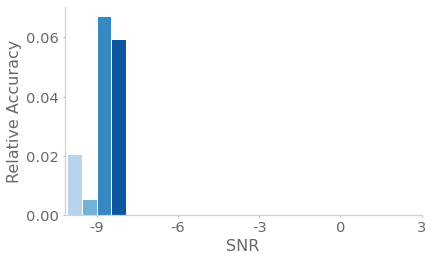

0.03087671850349336


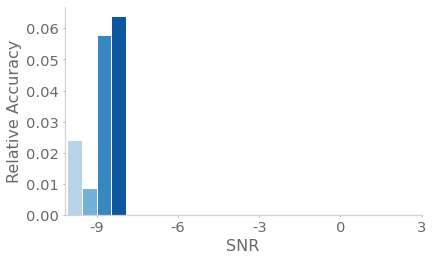

0.03281120877469762


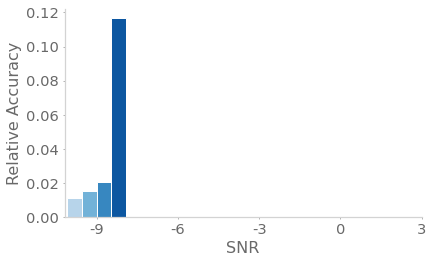

0.03196979941401848


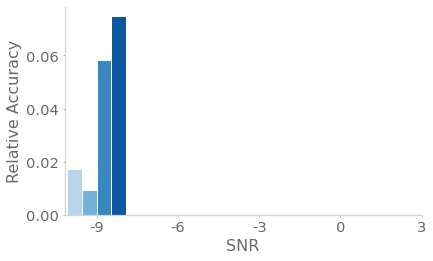

0.009627375854556383


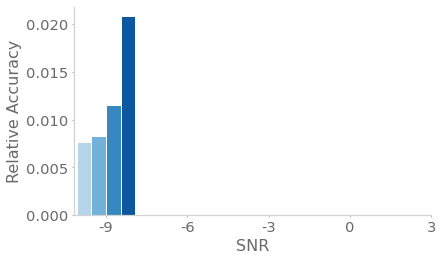

0.00979846657266012


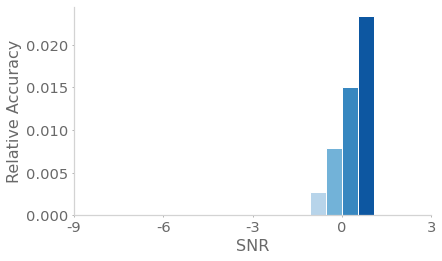

0.0026048813145587327


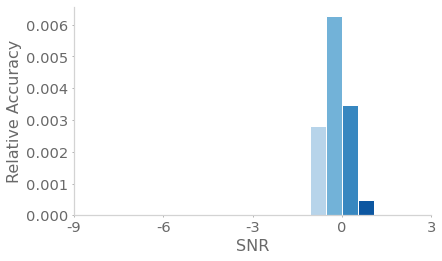

0.014389713744552455


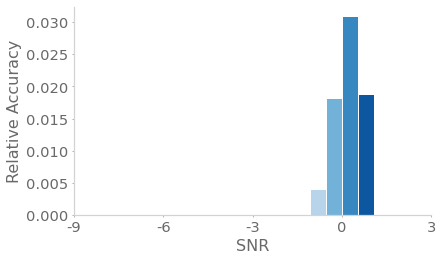

0.003567401865274206


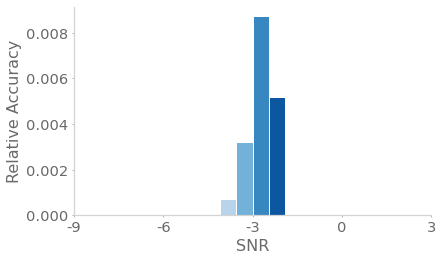

0.009281316454568735


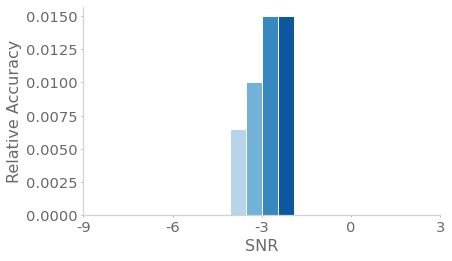

0.0020512820512820513


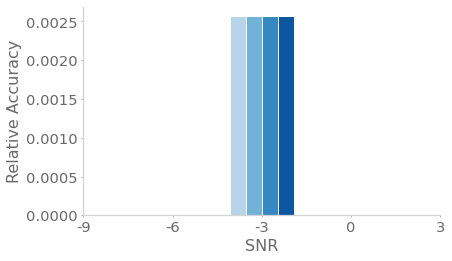

0.0036465999383932515


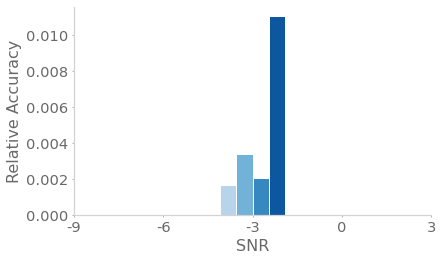

-0.01592734857172547


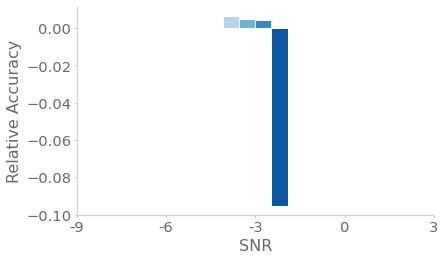

-0.0034717348927875247


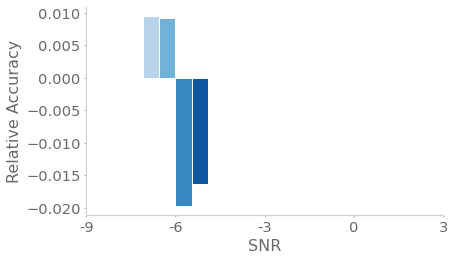

0.01984600389863548


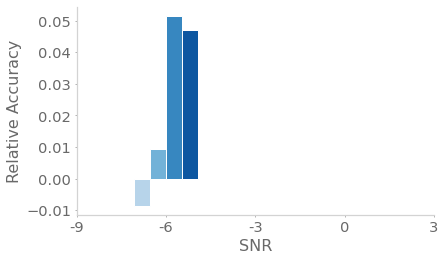

0.0015029239766081873


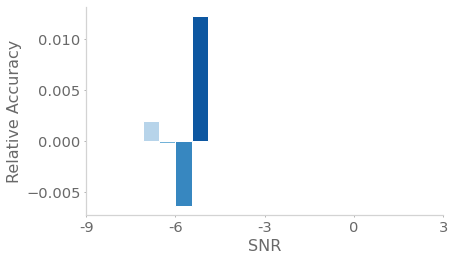

0.01652436647173489


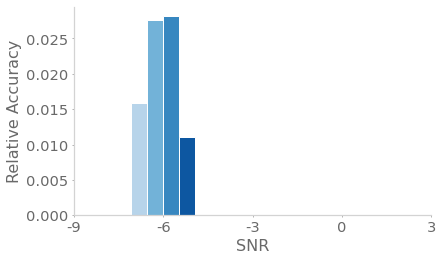

0.0031169590643274855


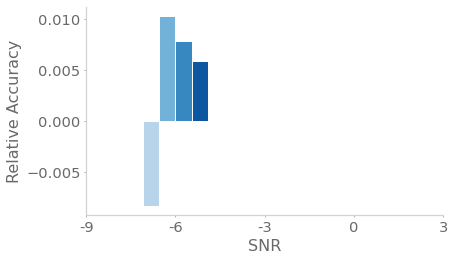

0.0017414858602826334


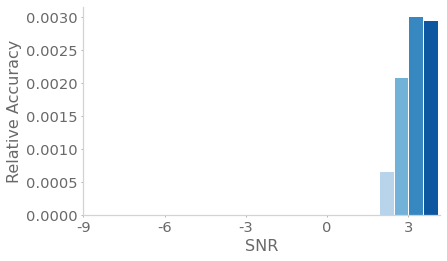

-0.002250351617440224


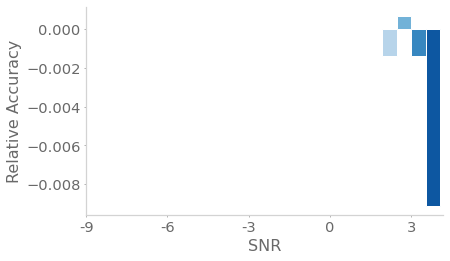

0.0015756615082226366


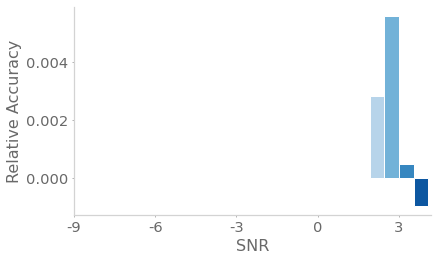

0.014024390243902438


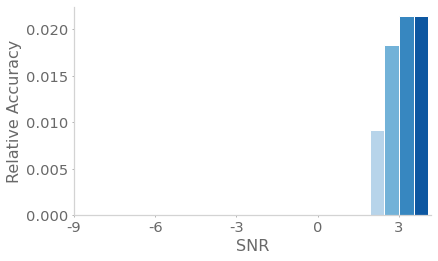

-0.0006097560975609756


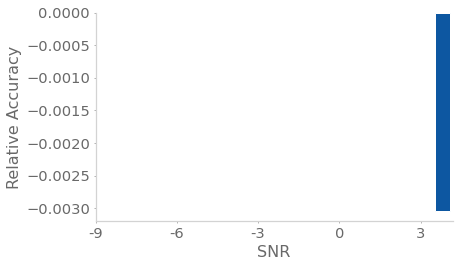

In [14]:
plot_by_snr_individual('Relative Accuracy')

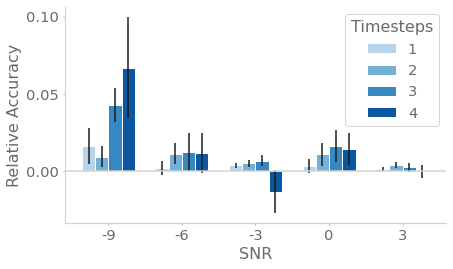

In [15]:
plot_by_snr_mean(
    'Relative Accuracy', figname='snr_acc_separate',
    yticks=[0, 0.05, 0.1]
    )

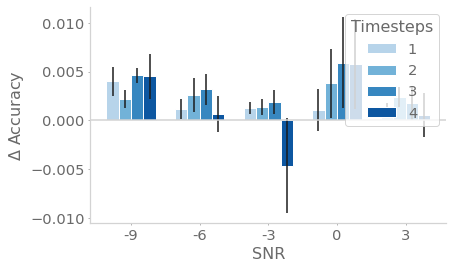

In [16]:
plot_by_snr_mean('$\Delta$ Accuracy')

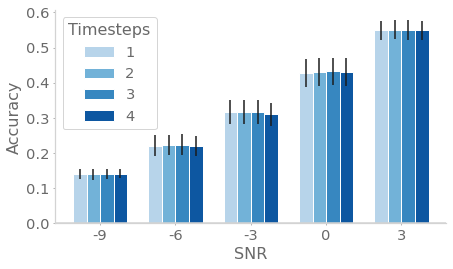

In [17]:
plot_by_snr_mean('Accuracy')

# Collapsed across SNR

0.03054240853429495


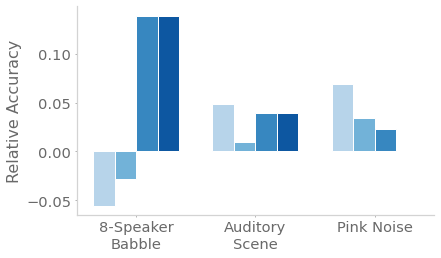

0.03087671850349336


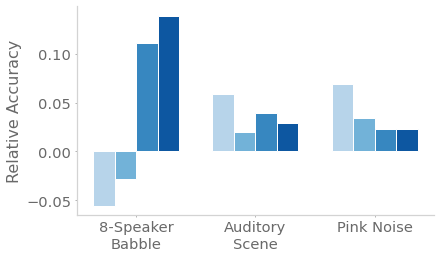

0.03281120877469762


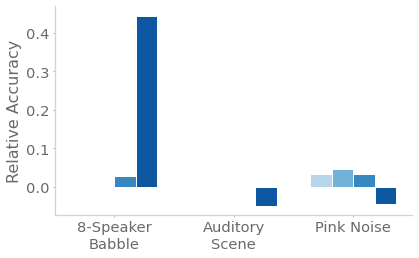

0.03196979941401848


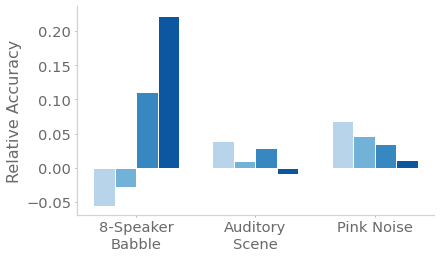

0.009627375854556383


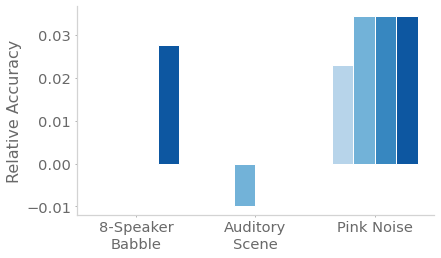

0.00979846657266012


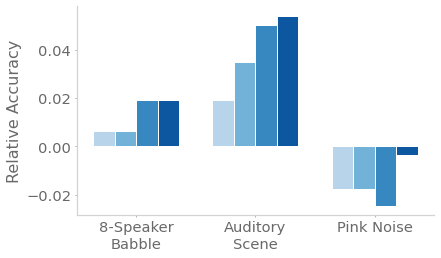

0.0026048813145587327


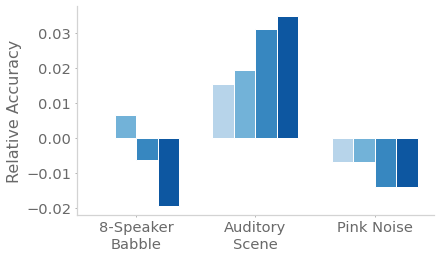

0.014389713744552455


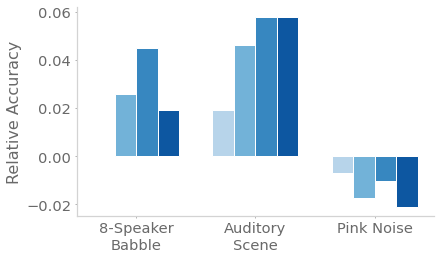

0.003567401865274206


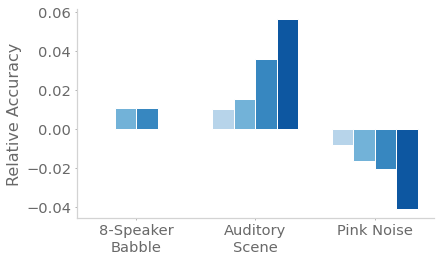

0.009281316454568735


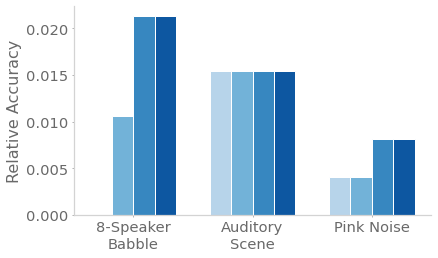

0.0020512820512820513


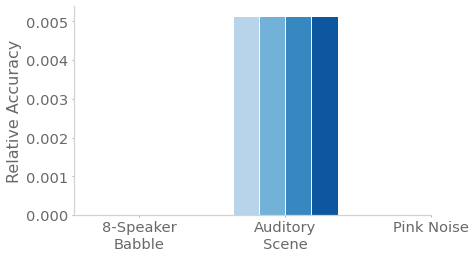

0.0036465999383932515


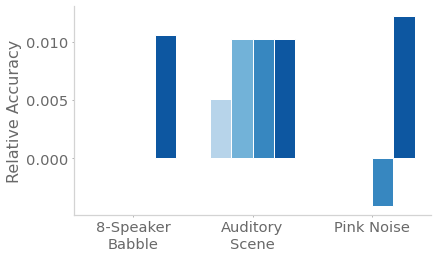

-0.01592734857172547


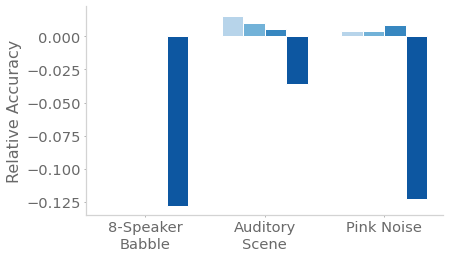

-0.0034717348927875247


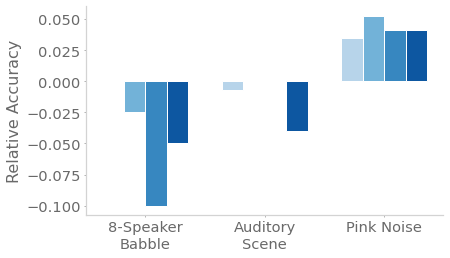

0.01984600389863548


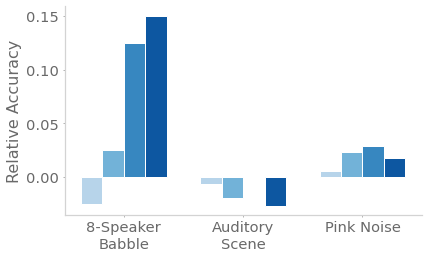

0.0015029239766081873


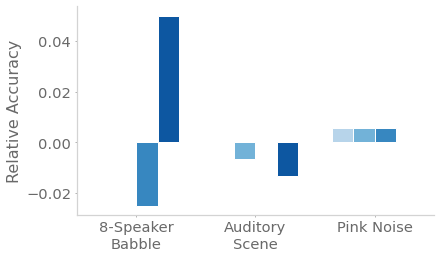

0.01652436647173489


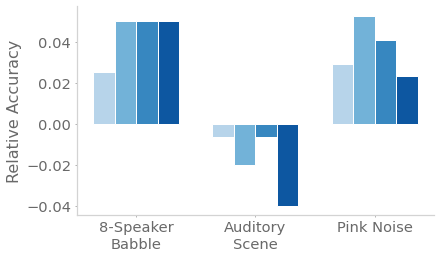

0.0031169590643274855


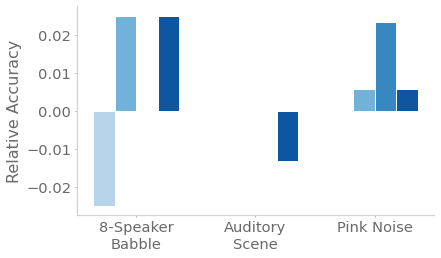

0.0017414858602826334


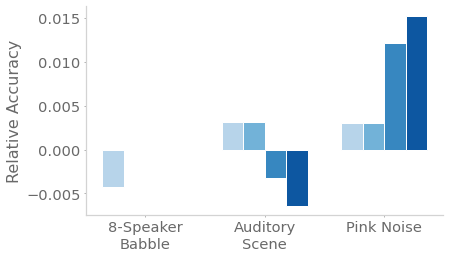

-0.002250351617440224


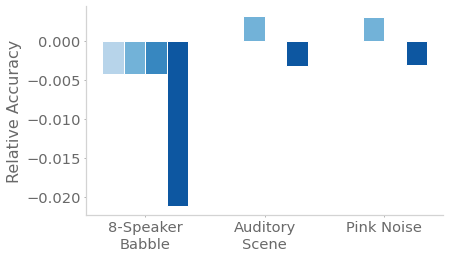

0.0015756615082226366


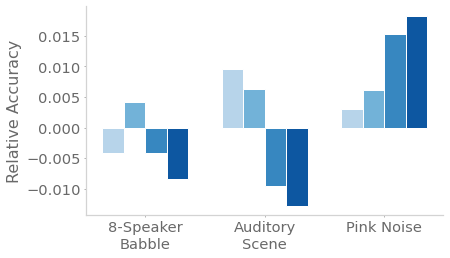

0.014024390243902438


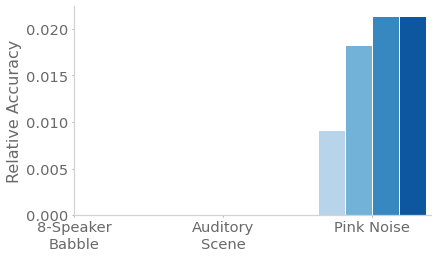

-0.0006097560975609756


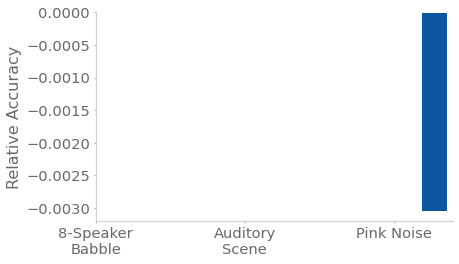

In [18]:
plot_by_bg_individual('Relative Accuracy')

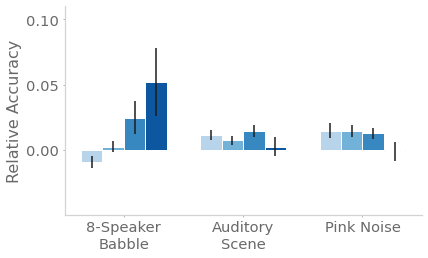

In [25]:
plot_by_bg_mean(
    'Relative Accuracy', figname='bg_acc_separate',
    yticks=[0, 0.05, 0.1], ylim=[-0.05, 0.11])

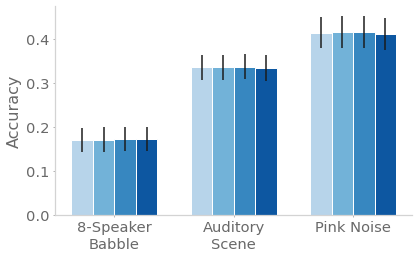

In [20]:
plot_by_bg_mean('Accuracy')